In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Random Validation Images:


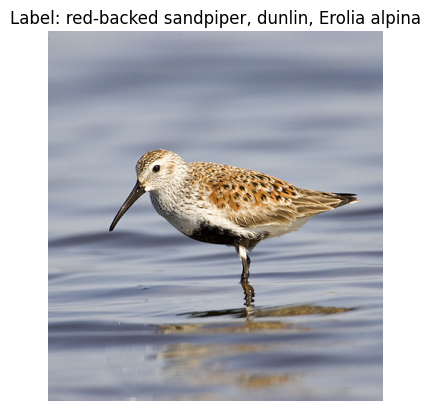

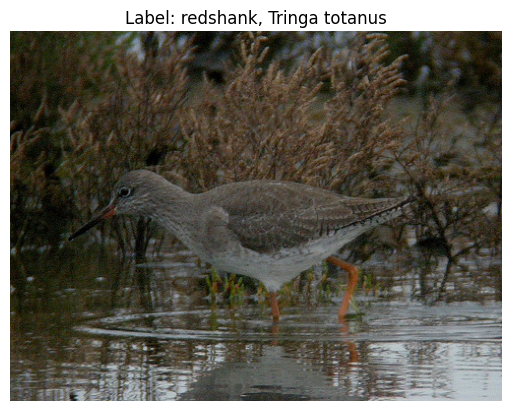

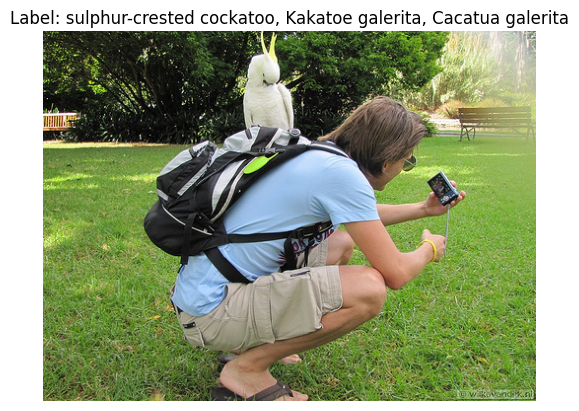

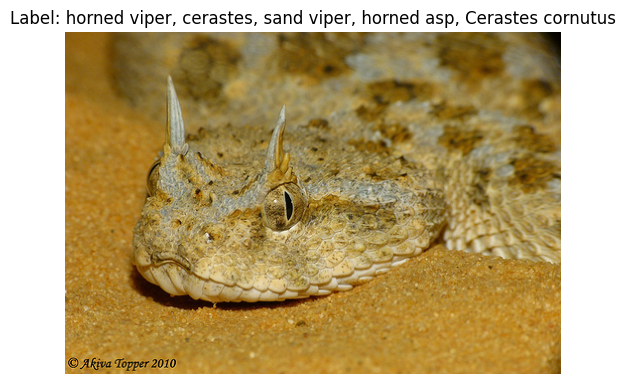

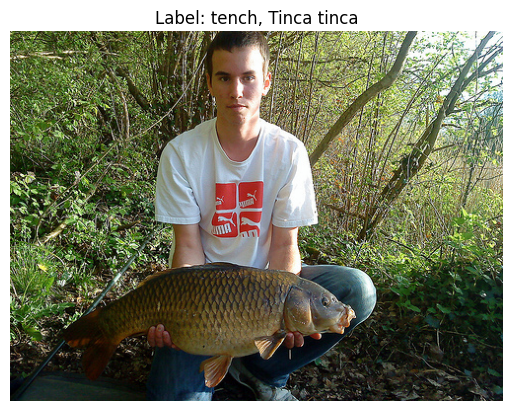

Random Training Images:


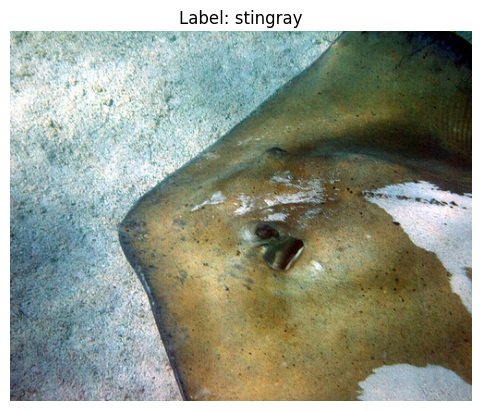

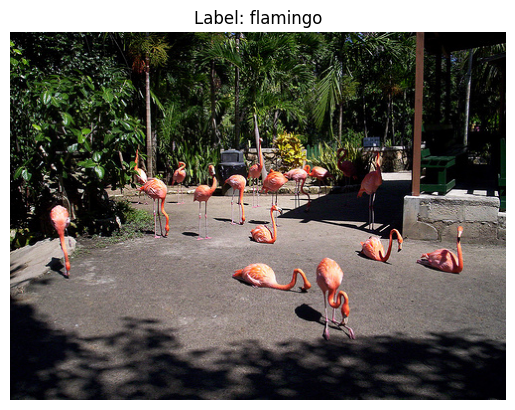

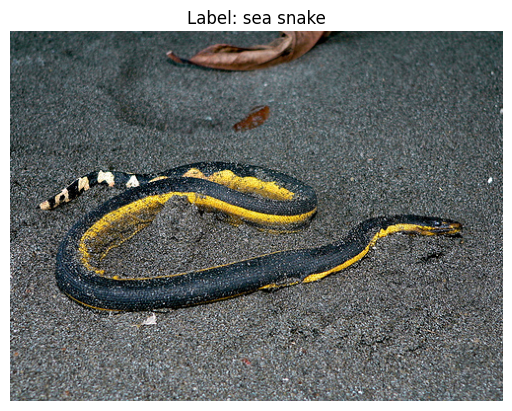

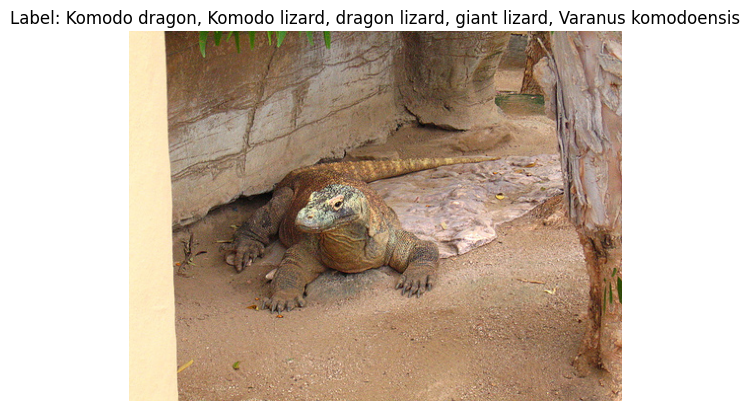

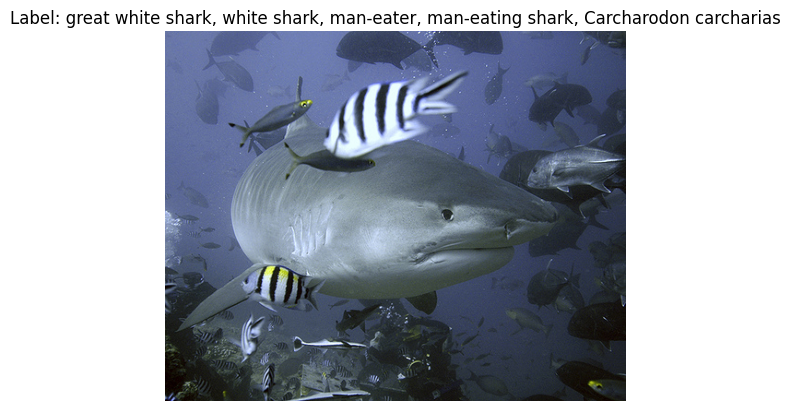

In [2]:
import json
import os
import random
import matplotlib.pyplot as plt
import cv2

# Load labels from JSON file
with open('/kaggle/input/imagenet100/Labels.json', 'r') as f:
    labels = json.load(f)

# Create a mapping from class ID to class name
id_to_class = {str(k): v for k, v in labels.items()}

# Function to display an image with its label
def show_image_with_label(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Directories containing the images
base_train_dir = '/kaggle/input/imagenet100'
val_dir = os.path.join(base_train_dir, 'val.X')
train_dirs = [os.path.join(base_train_dir, f'train.X{i}') for i in range(1, 5)]

# Helper function to get a random sample of images from a directory
def get_random_images(data_dirs, num_samples=5):
    images = []
    all_files = []
    for data_dir in data_dirs:
        for label_id in os.listdir(data_dir):
            class_name = id_to_class.get(label_id, 'Unknown')
            files = os.listdir(os.path.join(data_dir, label_id))
            all_files.extend([(os.path.join(data_dir, label_id, filename), class_name) for filename in files])

    selected_files = random.sample(all_files, num_samples)
    for image_path, class_name in selected_files:
        images.append((image_path, class_name))
    return images

# Get random images from validation set
val_images = get_random_images([val_dir], 5)

# Get random images from all training directories
train_images = get_random_images(train_dirs, 5)

# Display random validation images
print("Random Validation Images:")
for image_path, label in val_images:
    show_image_with_label(image_path, label)

# Display random training images
print("Random Training Images:")
for image_path, label in train_images:
    show_image_with_label(image_path, label)

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Define transforms for ImageNet100
transform = transforms.Compose([
    transforms.Resize(256),  # Resize the shorter side to 256
    transforms.CenterCrop(224),  # Center crop to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [5]:
from torch.utils.data import Dataset

# Create a custom dataset class
class MultiFolderDataset(Dataset):
    def __init__(self, folders, transform=None):
        self.samples = []
        self.transform = transform
        for folder in folders:
            for label_id in os.listdir(folder):
                class_name = id_to_class.get(label_id, 'Unknown')
                files = os.listdir(os.path.join(folder, label_id))
                self.samples.extend([(os.path.join(folder, label_id, filename), label_id) for filename in files])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(sorted(id_to_class.keys()))}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        label = self.class_to_idx[label]
        return image, label

In [6]:
import torchvision.datasets as datasets
# Creating the Datasets
train_dataset = MultiFolderDataset(train_dirs, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

In [7]:
# DataLoaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [8]:
# Check dataset
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print (id_to_class)

Number of training images: 130000
Number of validation images: 5000
{'n01968897': 'chambered nautilus, pearly nautilus, nautilus', 'n01770081': 'harvestman, daddy longlegs, Phalangium opilio', 'n01818515': 'macaw', 'n02011460': 'bittern', 'n01496331': 'electric ray, crampfish, numbfish, torpedo', 'n01847000': 'drake', 'n01687978': 'agama', 'n01740131': 'night snake, Hypsiglena torquata', 'n01537544': 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'n01491361': 'tiger shark, Galeocerdo cuvieri', 'n02007558': 'flamingo', 'n01735189': 'garter snake, grass snake', 'n01630670': 'common newt, Triturus vulgaris', 'n01440764': 'tench, Tinca tinca', 'n01819313': 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita', 'n02002556': 'white stork, Ciconia ciconia', 'n01667778': 'terrapin', 'n01755581': 'diamondback, diamondback rattlesnake, Crotalus adamanteus', 'n01924916': 'flatworm, platyhelminth', 'n01751748': 'sea snake', 'n01984695': 'spiny lobster, langouste, rock lobs

In [10]:
# Load pretrained AlexNet and modify it for ImageNet100
model = torchvision.models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(4096, 100)  # Change the output layer to match ImageNet100 classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Freeze feature extractor layers
for param in model.features.parameters():
    param.requires_grad = False

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 166MB/s]  


In [13]:
from tqdm import tqdm

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            tepoch.set_postfix(loss=(running_loss / (tepoch.n + 1)))

    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} completed. Loss: {running_loss / len(train_loader):.4f}")

print("Training completed!")

Epoch 1/10: 100%|██████████| 2032/2032 [09:25<00:00,  3.59batch/s, loss=1.22]


Epoch 1/10 completed. Loss: 1.2174


Epoch 2/10: 100%|██████████| 2032/2032 [07:02<00:00,  4.81batch/s, loss=0.828]


Epoch 2/10 completed. Loss: 0.8271


Epoch 3/10: 100%|██████████| 2032/2032 [06:57<00:00,  4.87batch/s, loss=0.652]


Epoch 3/10 completed. Loss: 0.6517


Epoch 4/10: 100%|██████████| 2032/2032 [06:57<00:00,  4.86batch/s, loss=0.523]


Epoch 4/10 completed. Loss: 0.5232


Epoch 5/10: 100%|██████████| 2032/2032 [06:57<00:00,  4.87batch/s, loss=0.425]


Epoch 5/10 completed. Loss: 0.4252


Epoch 6/10: 100%|██████████| 2032/2032 [06:54<00:00,  4.90batch/s, loss=0.362]


Epoch 6/10 completed. Loss: 0.3618


Epoch 7/10: 100%|██████████| 2032/2032 [07:00<00:00,  4.84batch/s, loss=0.311]


Epoch 7/10 completed. Loss: 0.3111


Epoch 8/10: 100%|██████████| 2032/2032 [07:00<00:00,  4.83batch/s, loss=0.275]


Epoch 8/10 completed. Loss: 0.2750


Epoch 9/10: 100%|██████████| 2032/2032 [06:54<00:00,  4.91batch/s, loss=0.251]


Epoch 9/10 completed. Loss: 0.2505


Epoch 10/10: 100%|██████████| 2032/2032 [06:55<00:00,  4.89batch/s, loss=0.234]

Epoch 10/10 completed. Loss: 0.2336
Training completed!


In [20]:
# Evaluation loop with tqdm
model.eval()
correct_top1 = 0
correct_top5 = 0
total = 0

# Wrap the validation DataLoader with tqdm
progress_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc="Evaluating")

with torch.no_grad():
    for i, (inputs, labels) in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get top-5 predictions
        _, top5_predictions = outputs.topk(5, dim=1)

        # Update total count
        total += labels.size(0)

        # Check top-1 accuracy
        correct_top1 += (top5_predictions[:, 0] == labels).sum().item()

        # Check top-5 accuracy
        correct_top5 += sum([labels[j] in top5_predictions[j] for j in range(labels.size(0))])

        # Update tqdm progress bar description
        progress_bar.set_postfix({
            "Top-1 Accuracy": 100 * correct_top1 / total,
            "Top-5 Accuracy": 100 * correct_top5 / total
        })

print(f"Top-1 Accuracy on the validation set: {100 * correct_top1 / total:.2f}%")
print(f"Top-5 Accuracy on the validation set: {100 * correct_top5 / total:.2f}%")

Evaluating: 100%|██████████| 79/79 [00:15<00:00,  4.97it/s, Top-1 Accuracy=69.2, Top-5 Accuracy=90.6]

Top-1 Accuracy on the validation set: 69.16%
Top-5 Accuracy on the validation set: 90.64%


In [15]:
# Save the trained model
model_path = "alexnet_imagenet100.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to alexnet_imagenet100.pth


In [11]:
# Loading the model
pathway = '/kaggle/input/alexnetimagenet100/pytorch/default/1/alexnet_imagenet100.pth'
model.load_state_dict(torch.load(pathway))

/tmp/ipykernel_30/3071446904.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pathway))


<All keys matched successfully>

In [12]:
!pip install torchattacks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-b

# FGSM Attack

In [26]:
import torchattacks

# FGSM Attack
fgsm = torchattacks.FGSM(model, eps=0.3)  # epsilon defines the perturbation strength
adv_examples_fgsm = []

# Apply FGSM attack
model.eval()
for inputs, labels in val_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # Generate adversarial examples
    adv_inputs = fgsm(inputs, labels)

    # Store adversarial examples
    adv_examples_fgsm.append((adv_inputs, labels))

# Check performance on adversarial examples
correct_top1 = 0
total = 0
for adv_inputs, labels in adv_examples_fgsm:
    outputs = model(adv_inputs)
    _, predictions = outputs.max(1)
    correct_top1 += (predictions == labels).sum().item()
    total += labels.size(0)

print(f"FGSM Top-1 Accuracy: {100 * correct_top1 / total:.2f}%")

FGSM Top-1 Accuracy: 4.36%


# PGD Attack

In [18]:
from tqdm import tqdm
import torchattacks 

# PGD Attack
pgd_attack = torchattacks.PGD(model, eps=0.001, alpha=2/255, steps=40)

# Function to test adversarial accuracy
def adversarial_test(attack, loader, attack_name):
    model.eval()
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(loader, desc=f"Adversarial Test ({attack_name})"):
        inputs, labels = inputs.to(device), labels.to(device)
        adv_inputs = attack(inputs, labels)
        outputs = model(adv_inputs)
        
        _, pred = outputs.max(1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)
    
    acc = correct / total
    print(f'{attack_name} Accuracy: {acc:.4f}')
    return acc

# Evaluate model with PGD attack
pgd_acc = adversarial_test(pgd_attack, val_loader, "PGD")

Adversarial Test (PGD): 100%|██████████| 79/79 [01:58<00:00,  1.50s/it]

PGD Accuracy: 0.2214


# CW Attack

In [21]:
import torchattacks
from tqdm import tqdm

# Set up CW Attack for the AlexNet model on ImageNet100
cw_attack = torchattacks.CW(model, c=1e-3, kappa=0, steps=100, lr=0.01)

# Function to evaluate adversarial accuracy using CW attack
def adversarial_test(attack, loader, attack_name):
    model.eval()  # Ensure the model is in eval mode
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(loader, desc=f"Adversarial Test ({attack_name})"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Generate adversarial examples
        adv_inputs = attack(inputs, labels)
        
        # Forward pass on adversarial images
        outputs = model(adv_inputs)
        _, predicted = outputs.max(1)
        
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    acc = correct / total
    print(f'{attack_name} Accuracy: {acc:.4f}')
    return acc

# Run CW attack evaluation on validation set
cw_acc = adversarial_test(cw_attack, val_loader, "CW")
print(f'Accuracy under CW Attack: {cw_acc * 100:.2f}%')

Adversarial Test (CW): 100%|██████████| 79/79 [01:58<00:00,  1.50s/it]

CW Accuracy: 0.2234
Accuracy under CW Attack: 22.34%
